In [109]:
import pandas as pd
import numpy as np
from IPython.display import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import re
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [110]:
!gdown 1POmzYEQZgZVqJO3F_cyNcd4QmoNE_mCv

Downloading...
From: https://drive.google.com/uc?id=1POmzYEQZgZVqJO3F_cyNcd4QmoNE_mCv
To: /content/bbc-news-data.csv
100% 5.08M/5.08M [00:00<00:00, 150MB/s]


In [111]:
df = pd.read_csv("/content/bbc-news-data.csv", sep="\t")
df

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [112]:
# Dropping the empty sub-title
print(df.shape)
df = df[((~df.title.isnull()) & (~df.content.isnull()))].reset_index(drop=True)
print(df.shape)

df

(2225, 4)
(2225, 4)


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


Text(0, 0.5, 'Count')

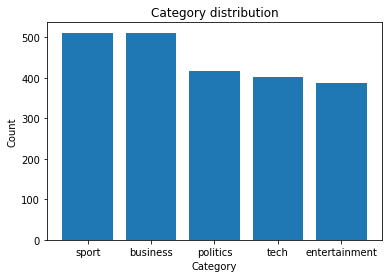

In [113]:
plt.bar(df.category.value_counts().index, df.category.value_counts().values)
plt.title('Category distribution')
plt.xlabel("Category")
plt.ylabel("Count")

In [114]:
ind=1807
print(f'Title: {df.title[ind]}')
print(f'Category: {df.category[ind]}')

Title: Federer joins all-time greats
Category: sport


In [115]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
def data_cleaning(text):
    
    # Lower the words in the sentence
    cleaned = text.lower()
    
    # Replace the full stop with a full stop and space
    cleaned = cleaned.replace(".", ". ")

    # Remove the stop words
    tokens = [word for word in cleaned.split() if not word in stop_words]
    
    # Remove the punctuations
    tokens = [tok.translate(str.maketrans(' ', ' ', string.punctuation)) for tok in tokens]
    
    # Joining the tokens back to form the sentence
    cleaned = " ".join(tokens)
    
    # Remove any extra spaces
    cleaned = cleaned.strip()
    
    return cleaned


In [117]:
for index, data in tqdm(df.iterrows(), total=df.shape[0]): #tqdm used to track progress,#iterrows generates iterator object with index object and row object(pandas series object)
    df.loc[index, 'title'] = data_cleaning(data['title']) #df.loc[index,'title'] returns title at that particular index

100%|██████████| 2225/2225 [00:01<00:00, 2120.05it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


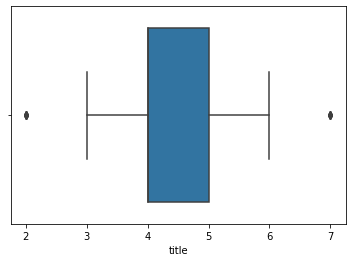

In [118]:
sns.boxplot(df['title'].str.split(" ").str.len()) #to check max length in a title

In [119]:
max_sentence_len = df['title'].str.split(" ").str.len().max()
total_classes = df.category.nunique()

print(f"Maximum sequence length: {max_sentence_len}")
print(f"Total classes: {total_classes}")

Maximum sequence length: 7
Total classes: 5


In [120]:
np.random.seed(100)                                                   #reset_drop-True deletes the index column and reset the index back to 0,1,2..
train_X, test_X, train_Y, test_Y = train_test_split(df['title'], 
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=100)
train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)

In [121]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1780,), (1780,), (445,), (445,))

In [122]:
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

In [123]:
train_Y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [124]:
validation = test_Y.argmax(axis=1)

In [125]:
def tokenize_and_pad(inp_text, max_len, tok):

    text_seq = tok.texts_to_sequences(inp_text)
    text_seq = pad_sequences(text_seq, maxlen=max_len, padding='post')
    
    return text_seq

text_tok = Tokenizer()
text_tok.fit_on_texts(train_X)
train_text_X = tokenize_and_pad(inp_text=train_X, max_len=max_sentence_len, tok=text_tok)
test_text_X = tokenize_and_pad(inp_text=test_X, max_len=max_sentence_len, tok=text_tok)
vocab_size = len(text_tok.word_index)+1

print("Overall text vocab size", vocab_size)

Overall text vocab size 3360


In [126]:
word2veclist

['the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'for',
 'is',
 'that',
 'on',
 'said',
 'it',
 'was',
 'he',
 'be',
 'with',
 'has',
 'as',
 'have',
 'at',
 'are',
 'by',
 'will',
 'but',
 'from',
 'not',
 'i',
 'his',
 'mr',
 'they',
 'this',
 'an',
 'which',
 'we',
 'had',
 'would',
 'been',
 'their',
 'more',
 'its',
 'up',
 'were',
 'also',
 'year',
 'who',
 'people',
 'new',
 'one',
 'us',
 'about',
 'there',
 'out',
 'after',
 'or',
 'than',
 'all',
 'can',
 'if',
 'could',
 'you',
 'last',
 'over',
 'when',
 'first',
 'time',
 'two',
 'into',
 'so',
 'now',
 'other',
 'some',
 'what',
 'she',
 'years',
 'world',
 'against',
 'them',
 'no',
 'only',
 'government',
 'make',
 'just',
 'told',
 'uk',
 'being',
 'do',
 'best',
 'like',
 'game',
 "it's",
 'such',
 'get',
 'made',
 'many',
 'very',
 'film',
 'music',
 '000',
 'should',
 'because',
 'back',
 'while',
 'before',
 'her',
 'three',
 'most',
 'well',
 'next',
 'any',
 'number',
 '1',
 'way',
 'added',
 'take',
 'set',
 'market'

In [127]:
word2veclist=list(text_tok.word_index.keys())
#w2vcorpus=[item for items in word2veclist]

In [128]:
modelw2v = Word2Vec(word2veclist, min_count=3, size= 100, workers=4, window =5, sg = 1, negative=5)

In [129]:
type(modelw2v)

gensim.models.word2vec.Word2Vec

In [130]:
latent_dim=50
embedding_dim=100

In [131]:
seed=56
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, trainable=True))
model.add(SimpleRNN(latent_dim, recurrent_dropout=0.2, return_sequences=False, activation='tanh'))
model.add(Dense(total_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         336000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 343,805
Trainable params: 343,805
Non-trainable params: 0
_________________________________________________________________


In [132]:
tf.random.set_seed(seed)
np.random.seed(seed)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', 
                               mode='max', 
                               verbose=1, 
                               patience=5)

model.fit(x=train_text_X, y=train_Y, 
          validation_data=(test_text_X, test_Y),
          batch_size=64, 
          epochs=10, 
          callbacks=[early_stopping])

Epoch 1/10
28/28 [==============================] - 3s 25ms/step - loss: 1.5804 - acc: 0.2713 - val_loss: 1.5594 - val_acc: 0.2921
Epoch 2/10
28/28 [==============================] - 1s 26ms/step - loss: 1.2862 - acc: 0.5888 - val_loss: 1.3880 - val_acc: 0.4472
Epoch 3/10
28/28 [==============================] - 1s 26ms/step - loss: 0.6456 - acc: 0.8281 - val_loss: 0.8305 - val_acc: 0.7101
Epoch 4/10
28/28 [==============================] - 1s 27ms/step - loss: 0.2494 - acc: 0.9421 - val_loss: 0.7788 - val_acc: 0.7596
Epoch 5/10
28/28 [==============================] - 1s 27ms/step - loss: 0.1162 - acc: 0.9803 - val_loss: 0.7634 - val_acc: 0.7933
Epoch 6/10
28/28 [==============================] - 0s 17ms/step - loss: 0.0661 - acc: 0.9893 - val_loss: 0.7810 - val_acc: 0.7843
Epoch 7/10
28/28 [==============================] - 0s 14ms/step - loss: 0.0370 - acc: 0.9966 - val_loss: 0.8274 - val_acc: 0.7798
Epoch 8/10
28/28 [==============================] - 0s 13ms/step - loss: 0.0285 - a

In [133]:
model.save("BCC_classifier.h5")

In [134]:
model = tf.keras.models.load_model("BCC_classifier.h5")

In [135]:
prediction = model.predict(test_text_X)
prediction = prediction.argmax(axis=1)
print(f"Accuracy: {accuracy_score(prediction, validation)}")

14/14 [==============================] - 0s 2ms/step
Accuracy: 0.7797752808988764


Text(0.5, 1.0, 'Confusion Matrix')

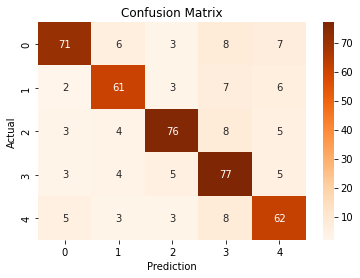

In [136]:
cm = confusion_matrix(validation, prediction)

# print("")
# plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, cmap='Oranges')
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix")